In [1]:
#Bibliotecas core
import pandas as pd
import numpy as np
import math

#Statsmodel para criação dos modelos de regressão linear e avaliação das métricas
import statsmodels.formula.api as sm
import statsmodels.api         as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

#SKLearn para o split da base, pipeline com transformação das colunas, criação do modelo RandomForest e avaliação do mesmo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

#Bibliotecas para plot
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração para mostrar os diagramas dos pipelines realizados com o SkLearn, apenas para melhorar a visualização de como o modelo está trabalhando.
from sklearn import set_config
set_config(display='diagram')


In [3]:
#Funções utilizadas posteriormente no código

#FUNÇÃO PARA CALCULAR O VIF
def calc_vif(dataframe):
    vif = pd.DataFrame()
    vif['variables'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return(vif)

#FUNÇÃO PARA EXIBIR AS MÉTRICAS DO MODELO
def imprimir_metricas (y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

<h2> 1. Leitura e processamento do dataframe </h2>

In [4]:
#A leitura é realizada a partir de uma base trabalhada anteriormente
df = pd.read_csv('Base_EMBRAESP_trabalhada.csv')
#df = df.drop(['MES_LAN', 'AGENTE', 'DATA_ENT', 'ZONA'], axis=1)

In [6]:
#Removi colunas que não seriam de nenhum interesse para o modelo (como ID e as "Unnamed") e também colunas de preço. Pensando que os preços devem ser altamente correlacionados, deixar 
#Valores na base não traria uma leitura muito interpretativa

#Base que será utilizada para o split 
df_rf = df.drop(['Unnamed: 0.1', 'Unnamed: 0','RENRESP91', 'PCMEDAU00',
       'PCMEDAU10', 'RENRESP00', 'ID', 'AGENTE', 'PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT', 'PC_AT_ATU', 'PC_EMP_ATU',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'PC_M2_AT_log', 'VLR_US__CO_log', 'PCMEDAU10_log', 'PCMEDAU91', 'PC_M2_AU_log'], axis=1)

df['AR_UT_UNID_log'] = np.log(df['AR_UT_UNID'])
df['RENRESP10_log'] = np.log(df['RENRESP10'])

<h3>1.1 Definindo as variáveis que estarão presentes no modelo</h3>

In [7]:
#Indicação das targets de cada modelo
target_au = 'PC_AU_ATU' #Target: Preço da área útil 
target_tt = 'PC_TT_ATU' #Target: Preço total da unidade

#As variáveis numéricas e categóricas que acabam sendo utilizadas posteriormente nos modelos de regressão linear
numericas = ['ANO_LAN', 'DORM_UNID', 'BANH_DORM', 'AR_UT_UNID']
categoricas = ['REGIAO', 'TIPO_EMP', 'AGENTE', 'CONSTRUTOR']
features = numericas + categoricas

#Variáveis que serão utilizadas no modelo de RF
numericas2 = df_rf.select_dtypes(['int', 'float']).columns
numericas2 = numericas2.drop(['PC_AU_ATU', 'PC_TT_ATU'])
categoricas2 = df_rf.select_dtypes(['object', 'string']).columns


In [8]:
#Preenchendo as variáveis categóricas com o valor mais frequente, realizando isso para evitar posteriores erros no RF
for col in categoricas2:
    df[col] = df[col].fillna(df[col].mode())

#Realizando label encoder nas variáveis dos modelos de regressão linear
for col in categoricas:
    df[col] = LabelEncoder().fit_transform(df[col].array.reshape(-1, 1))

In [10]:
#Train_Test split
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop([target_au, target_tt], axis=1), df_rf[target_au], test_size=0.2)

<h2>2. Interpretando a formulação dos preços dos imóveis - Modelos de regressão linear </h2>

O modelo de regressão linear permite maior interpretabilidade das variáveis e da constituição do preço dos empreendimentos lançados. Contém alguma perda de performance em relação aos modelos mais avançados, como ensembles de Random Forest, mas são mais facilmente lidos.

<h3>2.1 - Criando o baseline</h3>
No modelo baseline foram consideradas variáveis que são intuitivamente conhecidas na descrição de um empreendimento imobiliário, como o número de dormitórios, o número de banheiros e a área do apartamento.

In [11]:
#Criando os modelos baseline do preço da área útil e da área total. A ideia é que os modelos posteriores consigam um R² maior e AIC/BIC menores
au_baseline = sm.ols(formula='PC_AU_ATU_log ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()
tt_baseline = sm.ols(formula='PC_TT_ATU_log ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()

au_baseline.summary()
tt_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_AU_ATU_log   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     975.6
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:35:46   Log-Likelihood:                -7689.2
No. Observations:               13548   AIC:                         1.539e+04
Df Residuals:                   13544   BIC:                         1.542e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4999      0.013    671.963      0.000       8.475       8.525
DORM_UNID     -0.2425      0.007    -33.874      0.000      -0.257      -0.228
BANH_UNID      0.2451      0.009     27.520      0.000       0.228       0.263
AR_UT_UNID     0.0020      0.000     15.954      0.000       0.002       0.002
==============================================================================
Omnibus:                       96.452   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.334
Skew:                           0.175   Prob(JB):                     2.21e-23
Kurtosis:                       3.250   Cond. No.                         429.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Percebe-se que as variáveis relacionadas apenas ao apartamento não explicam bem, sozinhas, a variação do preço da área útil. O grau de explicabilidade das variáveis se mantém abaixo dos 20% para o caso da variável resposta em forma absoluta e logarítimica. 

O estudo sobre a dinâmica imobiliária no mercado de São Paulo leva ao entendimento de que duas variáveis são cruciais para o entendimento do preço das unidades: O local do empreendimento e o ano de lançamento. O local do empreendimento importa porque uma cidade desigual como São Paulo contém uma alta variabilidade no preço da terra, que se reflete diretamente nos valores de compra e venda de aluguéis dos imóveis; o ano de lançamento mantém relações com a macroeconomia, no sentido de que embora a demanda por moradia sempre seja alta, em anos de boom econômico a oferta e a disponibilidade de renda crescem exponencialmente. 
A seguir, essas duas variáveis são inseridas no modelo da resposta logarítimica do preço da área útil da unidade. 

<h3>2.2 - Otimizando os modelos</h3>

In [13]:
#Variáveis utilizadas em cada um dos modelos
variaveis_au =['REGIAO', 'BANH_DORM', 'AR_UT_UNID', 'TIPO_EMP', 'RENRESP10_log', 'CONSTRUTOR', 'AGENTE']
variaveis_tt = ['REGIAO', 'BANH_DORM', 'AGENTE', 'RENRESP10_log', 'AR_TT_UNID']

#Modelos de regressão da área útil e total da unidade
regressao_au = sm.ols(formula='PC_AU_ATU_log ~ REGIAO + BANH_DORM + AR_UT_UNID + TIPO_EMP + RENRESP10_log + AGENTE', data=df.iloc[X_train.index,:]).fit()
regressao_tt = sm.ols(formula='PC_TT_ATU_log ~ DORM_UNID + REGIAO + AGENTE + RENRESP10_log + AR_TT_UNID', data=df.iloc[X_train.index,:]).fit()            

regressao_au.summary()
regressao_tt.summary()

<h3>2.3 - Verificando os requisitos de aceitabilidade do modelo</h3>

<h4>2.3.1 Multicolinearidade - Correlação entre variáveis e Variance Inflation Factor</h4>

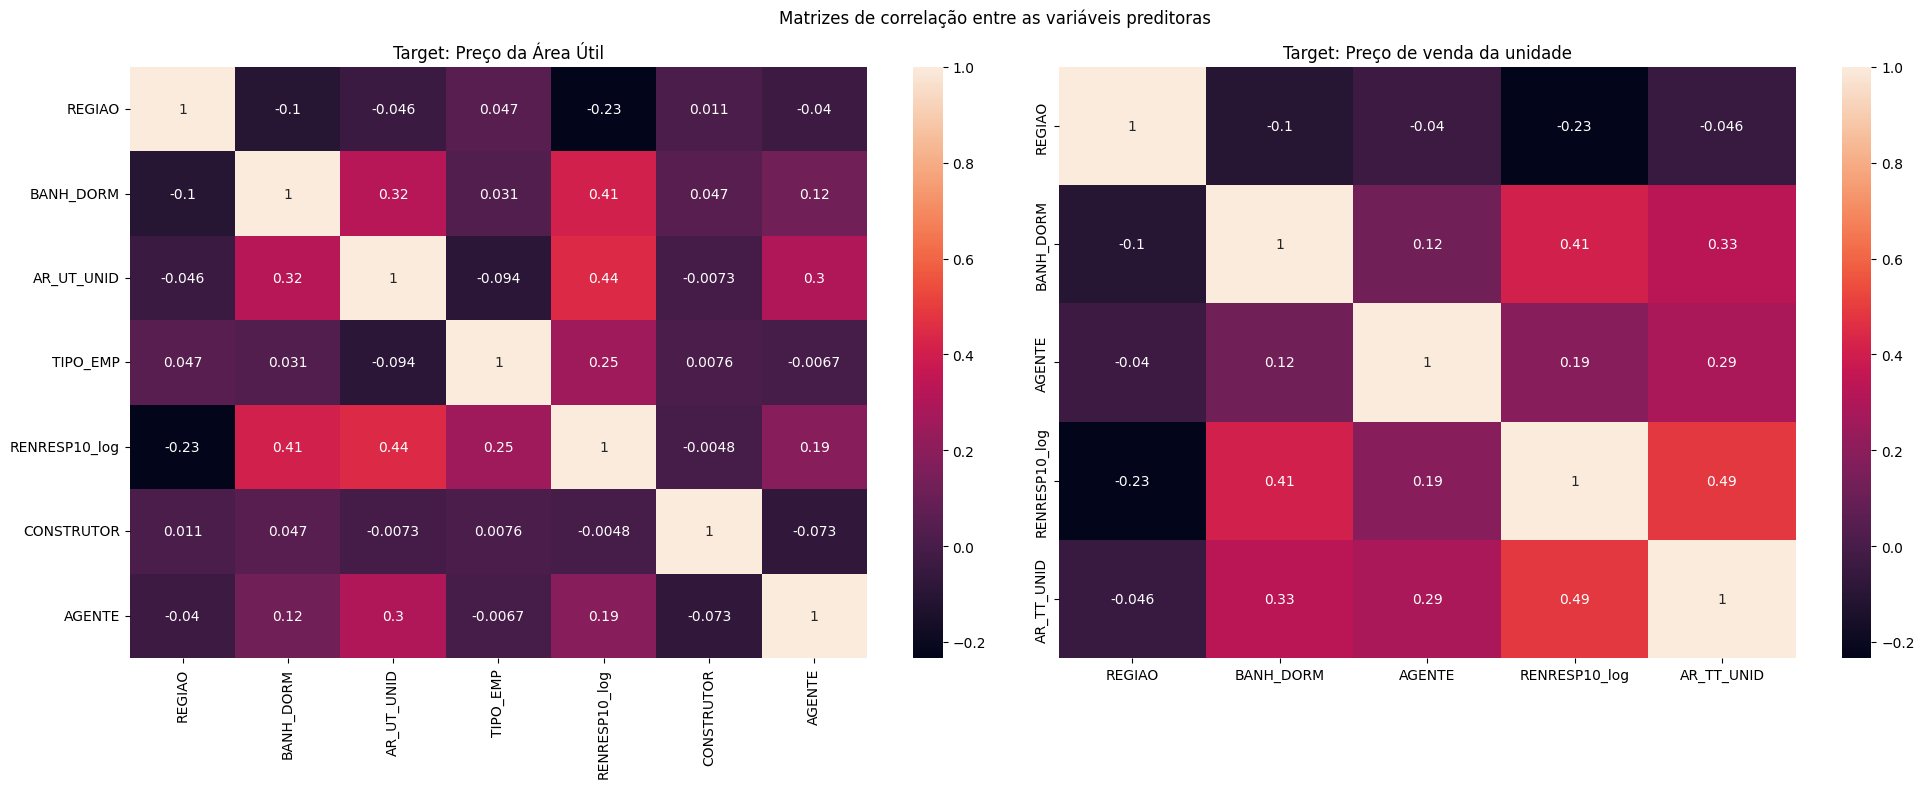

In [16]:
#Plotando as matrizes de correlação para identificar variáveis possivelmente muito relacionadas
fig, axs = plt.subplots(1, 2, figsize=(20,8), facecolor='white') 
axs1 = sns.heatmap(df[variaveis_au].corr(), annot=True, ax=axs[0])
axs2 = sns.heatmap(df[variaveis_tt].corr(), annot=True, ax=axs[1])

axs1.set_title(label='Target: Preço da Área Útil')
axs2.set_title(label='Target: Preço de venda da unidade')
fig.suptitle('Matrizes de correlação entre as variáveis preditoras')
fig.tight_layout()

In [17]:
#Variance Inflation Factor para verificar multicolinearidade entre as variáveis
vif_tt = calc_vif(df[variaveis_tt])
#print('vars: ', variaveis_tt)
print('Unidade - Variable Inflation Factors:', vif_tt.VIF.sum(), '\n')

vif_au = calc_vif(df[variaveis_au])
#print('vars: ', variaveis_au)
print('Área Útil - Variable Inflation Factors:', vif_au.VIF.sum(), '\n')


vars:  ['REGIAO', 'BANH_DORM', 'AGENTE', 'RENRESP10_log', 'AR_TT_UNID']
Variable Inflation Factors: 52.46571408568083 

vars:  ['REGIAO', 'BANH_DORM', 'AR_UT_UNID', 'TIPO_EMP', 'RENRESP10_log', 'CONSTRUTOR', 'AGENTE']
Variable Inflation Factors: 71.95626135832397 



<h4>2.3.2 Verificando heteroscedasticidade e normalização/distribuição dos resíduos</h4>

Text(0.51, 0.9, '(VIF - Valor da área útil: 71.96)')

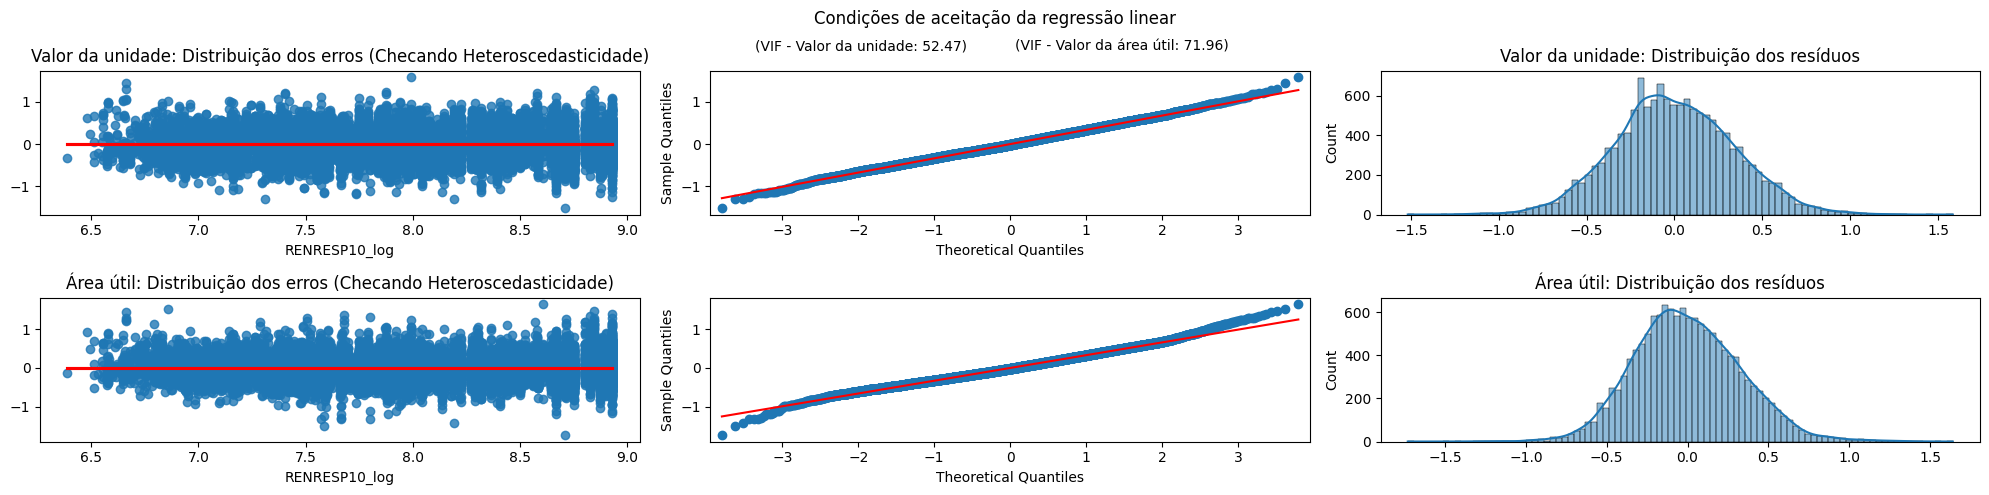

In [18]:

#Criando os subplots dos testes das regressões
fig, axs = plt.subplots(2, 3, figsize=(20,5), facecolor='white') 
ax00 = sns.regplot(x=X_train.RENRESP10_log, y=regressao_tt.resid, ax=axs[0,0], line_kws={'color':'red'})
ax01 = sma.qqplot(regressao_tt.resid, line="s", ax=axs[0,1])
ax02 = sns.histplot(regressao_tt.resid, kde=True, ax=axs[0,2])
ax10 = sns.regplot(x=X_train.RENRESP10_log, y=regressao_au.resid, ax=axs[1,0], line_kws={'color':'red'})
ax11 = sma.qqplot(regressao_au.resid, line="s", ax=axs[1,1])
ax12 = sns.histplot(regressao_au.resid, kde=True, ax=axs[1,2])

#Títulos dos subplots
ax00.set_title('Valor da unidade: Distribuição dos erros (Checando Heteroscedasticidade)')
ax01.suptitle('Valor da unidade: Distribuição dos resíduos (QQPlot)')
ax02.set_title('Valor da unidade: Distribuição dos resíduos')
ax10.set_title('Área útil: Distribuição dos erros (Checando Heteroscedasticidade)')
ax11.suptitle('Área útil: Distribuição dos resíduos (QQPlot)')
ax12.set_title('Área útil: Distribuição dos resíduos')

#Título geral
fig.suptitle('Condições de aceitação da regressão linear')
fig.tight_layout()
fig.text(s='(VIF - Valor da unidade: {})'.format(round(vif_tt.VIF.sum(), 2)), y=0.90, x=0.38)
fig.text(s='(VIF - Valor da área útil: {})'.format(round(vif_au.VIF.sum(), 2)), y=0.90, x=0.51)

<h2>3. Descobrindo os valores de m² e unidade - Modelos de RandomForest </h2>

<h4>3.1 - Criação de pipelines para adequação das features e criação do primeiro modelo</h4>

In [19]:
#Instanciando os pipelines de tratamento das variáveis do dataframe

#Tratamento numérico: input de dados faltantes e scaler 
num_pipeline = Pipeline(steps=[
    ("input", SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

#Tratamento categórico: One hot enconding para evitar erros no modelo
cat_pipeline = Pipeline(steps=[
    ("cat", OneHotEncoder(handle_unknown= 'ignore'))
    ])

#Column transformar aplicando os pipelines em todas as variáveis indicadas anteriormente
preprocessing = ColumnTransformer(transformers=[
    ('preprocessamento numerico', num_pipeline, numericas2),
    ('preprocessamento categorico', cat_pipeline, categoricas2)
])

#Pipeline do modelo de RandomForest aplicando o pré-processamento 
model = Pipeline(steps=[('Preprocessamento', preprocessing),
    ('regressao', RandomForestRegressor())])

<h4>3.2 - Verificando overfitting por meio de validação cruzada</h4>

In [22]:
#Relizando o cross validation para identificar possível overfitting no modelo
scores = cross_val_score(model, X_train, y_train, cv=6, scoring='neg_mean_squared_error', n_jobs=-1)
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

<h4>3.3 - Hiperparametrização - selecionando o melhor conjunto de parâmetros para o modelo a partir de Random/Grid Search</h4>

In [25]:
#Verificando os parâmetros default do RandomFOrest
print('Parâmetros default: \n')
print(model[1].get_params())

Parâmetros default: 

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [34]:
#Estabelecendo alguns limites para o random_grid trabalhar em cima e fazer uma pré-seleção dos melhores parâmetros

#Número de árvores
n_estimators = [int(x) for x in np.linspace(start=1, stop=100, num=10)]
#Colunas a serem escolhidas
max_features = [1.0, 'sqrt']
#Profundidade de cada árvore
max_depth = [int(x) for x in np.linspace(1, 50, 10)]
#Amostras até criar nó
min_samples_split = [2,5,10]
#Método de seleção das amostras
bootstrap = [True, False]

random_grid = {'regressao__n_estimators': n_estimators,
               'regressao__max_features': max_features,
               'regressao__max_depth': max_depth,
               'regressao__min_samples_split': min_samples_split,
               'regressao__bootstrap': bootstrap}

print(random_grid)

{'regressao__n_estimators': [1, 12, 23, 34, 45, 56, 67, 78, 89, 100], 'regressao__max_features': [1.0, 'sqrt'], 'regressao__max_depth': [1, 6, 11, 17, 22, 28, 33, 39, 44, 50], 'regressao__min_samples_split': [2, 5, 10], 'regressao__bootstrap': [True, False]}


In [35]:
#Rodando o modelo de pré-seleção dos hiperparâmetros
modeL_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=10, cv=3, jobs=-1)
modeL_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('Preprocessamento',
                                              ColumnTransformer(transformers=[('preprocessamento '
                                                                               'numerico',
                                                                               Pipeline(steps=[('input',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['ANO_LAN', 'DORM_UNID', 'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB',
       'BLOCOS', 'UNIDAND', 'ANDARES', 'AR_UT_UNID', 'AR_TT_UNID',
       'AR_TT_TERR', 'TT_UNID', 'DO...
       'TIPO_VIA', 'ZONA', 'SIST_FINAN', 'INCORPORAD', 'CONSTRUTOR',
       'INCORPOR_A', 'CONSTRUT_A', 'REGIAO'],
      dtype='object'))])),
                                             ('regressao',
                                              RandomForestRegressor())]),
                   param_distributions={'regressao__bootstrap': [True, False],
                                        'regressao__max_depth': [1, 6, 11, 17,
                                                                 22, 28, 33, 39,
                                                                 44, 50],
                                        'regressao__max_features': [1.0,
                                                                    'sqrt'],
                                        'regressao__min_samples_split': [2, 5,
                                                                         10],
                                        'regressao__n_estimators': [1, 12, 23,
                                                                    34, 45, 56,
                                                                    67, 78, 89,
                                                                    100]})

In [36]:
modeL_random.best_params_

{'regressao__n_estimators': 67,
 'regressao__min_samples_split': 2,
 'regressao__max_features': 1.0,
 'regressao__max_depth': 33,
 'regressao__bootstrap': False}

In [37]:
#FAZENDO O GRID SEARCH

'''param_grid = {
    'regressao__bootstrap': [True],
    'regressao__max_depth': [60, 70, 90, 110],
    'regressao__max_features': ['sqrt'],
    'regressao__min_samples_split': [3, 4, 5],
    'regressao__n_estimators': [170, 185, 200, 250]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)'''

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Preprocessamento',
                                        ColumnTransformer(transformers=[('preprocessamento '
                                                                         'numerico',
                                                                         Pipeline(steps=[('input',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ANO_LAN', 'DORM_UNID', 'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB',
       'BLOCOS', 'UNIDAND', 'ANDARES', 'AR_UT_UNID', 'AR_TT_UNID',
       'AR_TT_TERR', 'TT_UNID', 'DORM_EMP...
       'TIPO_VIA', 'ZONA', 'SIST_FINAN', 'INCORPORAD', 'CONSTRUTOR',
       'INCORPOR_A', 'CONSTRUT_A', 'REGIAO'],
      dtype='object'))])),
                                       ('regressao', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressao__bootstrap': [True],
                         'regressao__max_depth': [60, 70, 90, 110],
                         'regressao__max_features': ['sqrt'],
                         'regressao__min_samples_split': [3, 4, 5],
                         'regressao__n_estimators': [170, 185, 200, 250]})

In [ ]:
#FAZENDO O GRID SEARCH

param_grid = {
    'regressao__bootstrap': [False],
    'regressao__max_depth': [20, 30, 40, 50],
    'regressao__max_features': [1.0, 0.5, 'sqrt'],
    'regressao__min_samples_split': [2, 3, 4, 5],
    'regressao__n_estimators': [40, 50, 60, 67, 75, 90]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [44]:
grid_search.best_params_

{'regressao__bootstrap': True,
 'regressao__max_depth': 60,
 'regressao__max_features': 'sqrt',
 'regressao__min_samples_split': 3,
 'regressao__n_estimators': 170}

In [41]:
grid_search.best_params_
best_estimator = grid_search.best_estimator_

<h2>4. Rodando o modelo na base de teste e verificando a performance </h2>

In [43]:
y_pred = best_estimator.predict(X_test)

baseline_report = imprimir_metricas(y_test, y_pred)
baseline_report

,metric,valid
0,RMSE,1243.19
1,MAE,734.94
2,R^2,0.81
3,MAPE,0.14
4,Avg. target,5628.40
5,Avg. Prediction,5639.03


In [ ]:
model.

In [ ]:
feature_importances = model[1][1].feature_importances_

In [ ]:
permutation_result = permutation_importance(model, X_test, y_test, n_repeats=30)

In [ ]:
df_importancia = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
df_importancia.sort_values(by='importance', ascending=False, inplace=True)

Text(0.5, 0.98, 'Variáveis mais importantes no entendimento dos valores de residências vendidas')

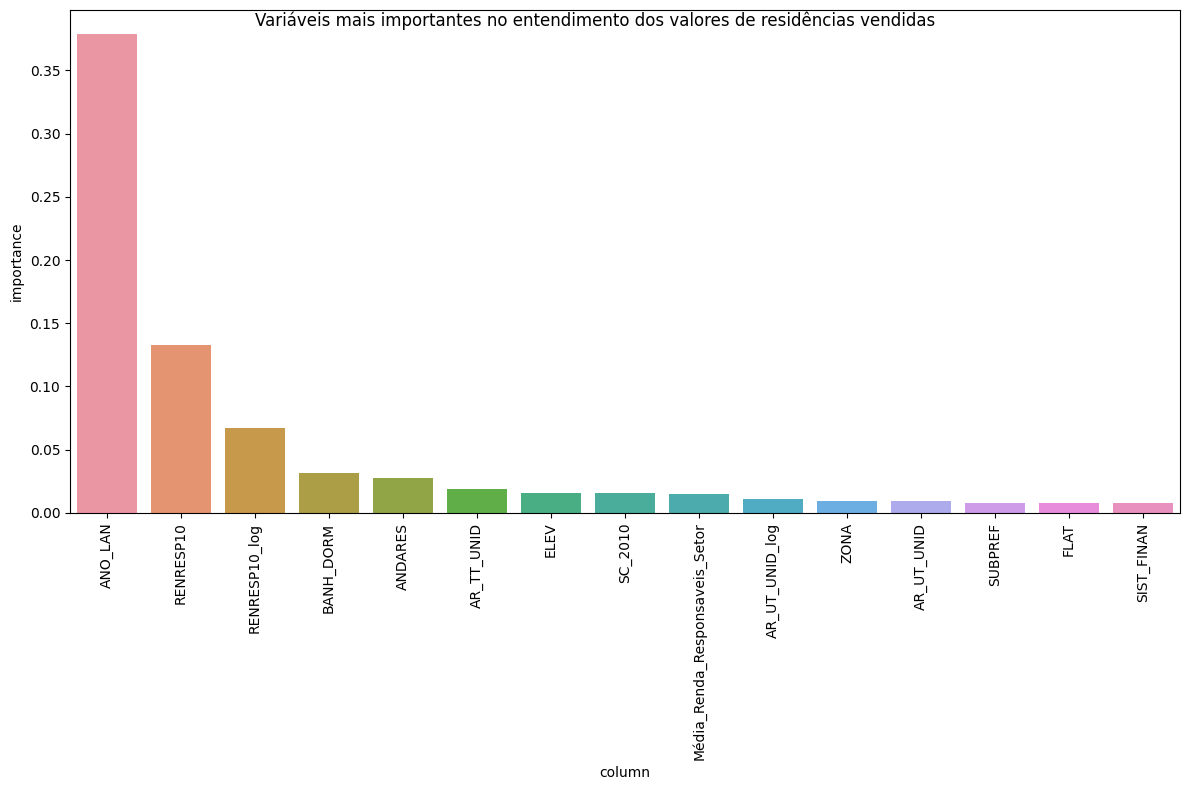

In [ ]:
fig, axs = plt.subplots(figsize=(12,8), facecolor='white')
ax = sns.barplot(x='column', y="importance", data=df_importancia.nlargest(15, 'importance'))
plt.xticks(rotation=90)
plt.tight_layout()

fig.suptitle('Variáveis mais importantes no entendimento dos valores de residências vendidas')

Conjunto 1: 0.65 (RandomF), 0.39 (RegressãoL)
Conjunto IBGE: 0.53 (RandomF), 0.26 (RegressãoL)
Conjunto 1_log: 0.69 (RandomF), 0.40 (RegressãoL)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
baseline_report = imprimir_metricas(y_test, y_pred)
baseline_report

,metric,valid
0,RMSE,0.20
1,MAE,0.14
2,R^2,0.82
3,MAPE,0.02
4,Avg. target,8.53
5,Avg. Prediction,8.53
